In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"afaq0456","key":"fc27cb2ead3b811d78dc5a8feffe64e8"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d saurabhshahane/fake-news-classification

Dataset URL: https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification
License(s): Attribution 4.0 International (CC BY 4.0)


In [5]:
!unzip fake-news-classification.zip

Archive:  fake-news-classification.zip
  inflating: WELFake_Dataset.csv     


In [6]:
df=pd.read_csv('WELFake_Dataset.csv')

In [7]:
df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


In [9]:
df.isna().sum()

,0
Unnamed: 0,0
title,558
text,39
label,0


In [7]:
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


In [8]:
# Fill missing 'title' and 'text' with an empty string
df["title"].fillna("", inplace=True)
df["text"].fillna("", inplace=True)

df.isna().sum()

<ipython-input-8-bae88dd62b1f>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["title"].fillna("", inplace=True)
<ipython-input-8-bae88dd62b1f>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({

,0
Unnamed: 0,0
title,0
text,0
label,0


In [9]:
# Print summary statistics for numeric columns
print("Summary Statistics for Numeric Columns:")
print(df.describe())

# Print summary statistics for non-numeric (object) columns
print("\nSummary Statistics for Object Columns:")
print(df.describe(include=['object']))

Summary Statistics for Numeric Columns:
         Unnamed: 0         label
count  72134.000000  72134.000000
mean   36066.500000      0.514404
std    20823.436496      0.499796
min        0.000000      0.000000
25%    18033.250000      0.000000
50%    36066.500000      1.000000
75%    54099.750000      1.000000
max    72133.000000      1.000000

Summary Statistics for Object Columns:
        title   text
count   72134  72134
unique  62348  62719
top                 
freq      558    738


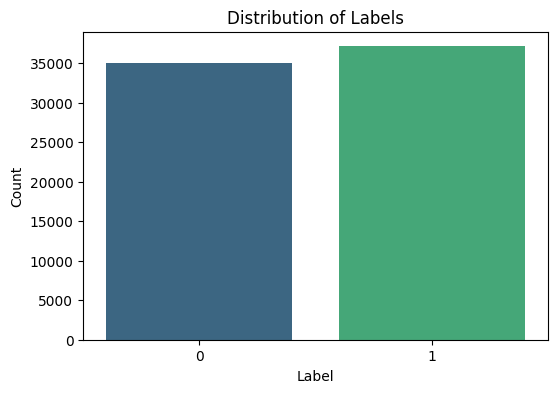

Label Counts:
 label
1    37106
0    35028
Name: count, dtype: int64


In [10]:
# Count occurrences of each label
label_counts = df["label"].value_counts()

plt.figure(figsize=(6, 4))
ax = sns.barplot(x=label_counts.index, y=label_counts.values, hue=label_counts.index, dodge=False, palette="viridis", legend=False)

# Add labels and title
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Distribution of Labels")
plt.xticks(rotation=0)
plt.show()

print("Label Counts:\n", label_counts)

Top 20 words in Fake News:
said: 1.0000
U S: 0.5924
one: 0.3707
Trump s: 0.2790
United State: 0.2719
people: 0.2664
will: 0.2510
Mr Trump: 0.2147
say: 0.2077
time: 0.2035
now: 0.1902
Donald Trump: 0.1857
percent: 0.1750
White House: 0.1711
many: 0.1634
even: 0.1621
country: 0.1613
New York: 0.1568
make: 0.1548
made: 0.1541

Top 20 words in Real News:
one: 1.0000
said: 0.9807
people: 0.9202
will: 0.7477
Donald Trump: 0.6658
now: 0.6416
say: 0.5929
U S: 0.5605
time: 0.5509
Trump s: 0.5486
U: 0.5408
Hillary Clinton: 0.5324
Trump: 0.5296
even: 0.5176
don t: 0.5108
know: 0.4868
way: 0.4562
make: 0.4410
State: 0.4344
country: 0.4235


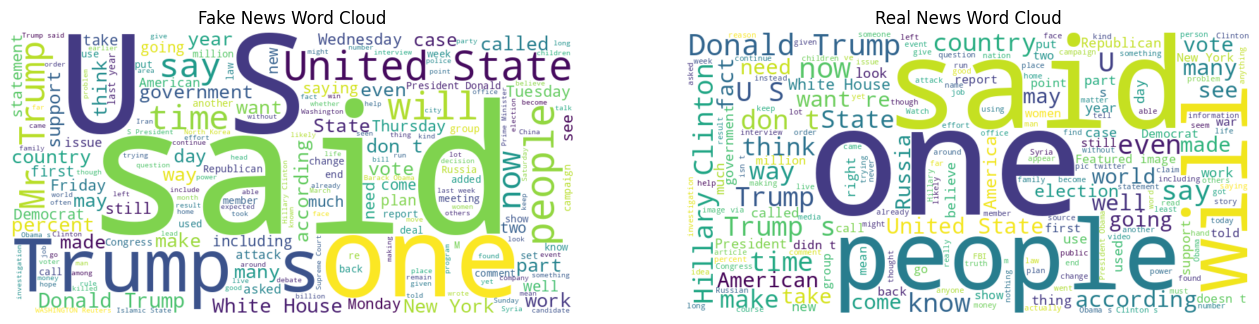

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all fake and real news texts
fake_text = ' '.join(df[df['label'] == 0]['text'].astype(str))
real_text = ' '.join(df[df['label'] == 1]['text'].astype(str))

# Generate word clouds
wc_fake = WordCloud(width=800, height=400, background_color='white').generate(fake_text)
wc_real = WordCloud(width=800, height=400, background_color='white').generate(real_text)

# Print top 20 words and frequencies for fake news
print("Top 20 words in Fake News:")
for word, freq in list(wc_fake.words_.items())[:20]:
    print(f"{word}: {freq:.4f}")

print("\nTop 20 words in Real News:")
for word, freq in list(wc_real.words_.items())[:20]:
    print(f"{word}: {freq:.4f}")

# Plot the word clouds
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(wc_fake, interpolation='bilinear')
plt.axis('off')
plt.title('Fake News Word Cloud')

plt.subplot(1, 2, 2)
plt.imshow(wc_real, interpolation='bilinear')
plt.axis('off')
plt.title('Real News Word Cloud')
plt.show()

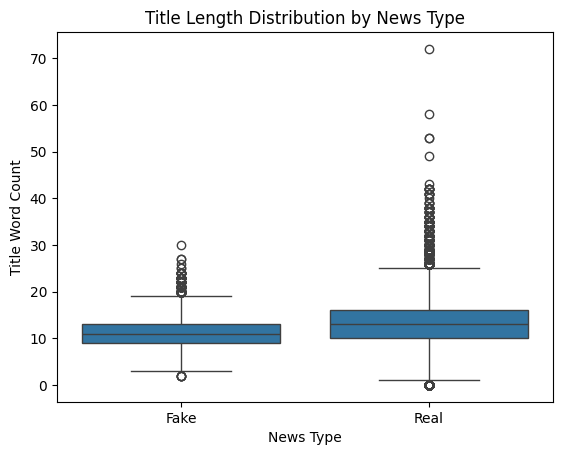


Top 10 Longest Titles - Fake News:
 title_length
           30
           27
           27
           26
           25
           25
           24
           24
           24
           24

Top 10 Longest Titles - Real News:
 title_length
           72
           58
           53
           53
           49
           43
           42
           42
           42
           42


In [18]:
# Boxplot visualization
sns.boxplot(x='label', y='title_length', data=df)
plt.xticks([0, 1], ['Fake', 'Real'])
plt.title('Title Length Distribution by News Type')
plt.xlabel('News Type')
plt.ylabel('Title Word Count')
plt.show()

# Get top 10 longest titles for each category
top_fake = df[df['label'] == 0].nlargest(10, 'title_length')[['title_length']]
top_real = df[df['label'] == 1].nlargest(10, 'title_length')[['title_length']]

# Print results
print("\nTop 10 Longest Titles - Fake News:")
print(top_fake.to_string(index=False))

print("\nTop 10 Longest Titles - Real News:")
print(top_real.to_string(index=False))

# **Text Preprocessing and Cleaning Pipeline**

In [ ]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
lemmatizer = WordNetLemmatizer()

# Download NLTK resources
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

def clean_text(text):
    # 1: Lowercasing
    text = text.lower()

    # 2: Remove special characters, numbers, and punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # 3: Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    # 4: Remove stop words
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])

    # 6: Tokenization
    tokens = word_tokenize(text)

    # 6: Lemmatization
    text = ' '.join([lemmatizer.lemmatize(word) for word in tokens])

    # 7: Remove URLs, mentions, and hashtags
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)

    # 8: Remove non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)

    return text
df['cleaned_text'] = df['text'].apply(lambda x: clean_text(x))

print(df[['text', 'cleaned_text']].head())

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


                                                text  \
0  No comment is expected from Barack Obama Membe...   
1     Did they post their votes for Hillary already?   
2   Now, most of the demonstrators gathered last ...   
3  A dozen politically active pastors came here f...   
4  The RS-28 Sarmat missile, dubbed Satan 2, will...   

                                        cleaned_text  
0  comment expected barack obama member fyf fukyo...  
1                          post vote hillary already  
2  demonstrator gathered last night exercising co...  
3  dozen politically active pastor came private d...  
4  r sarmat missile dubbed satan replace s fly mi...  


# **Word Cloud Visualization of Cleaned Text Data**

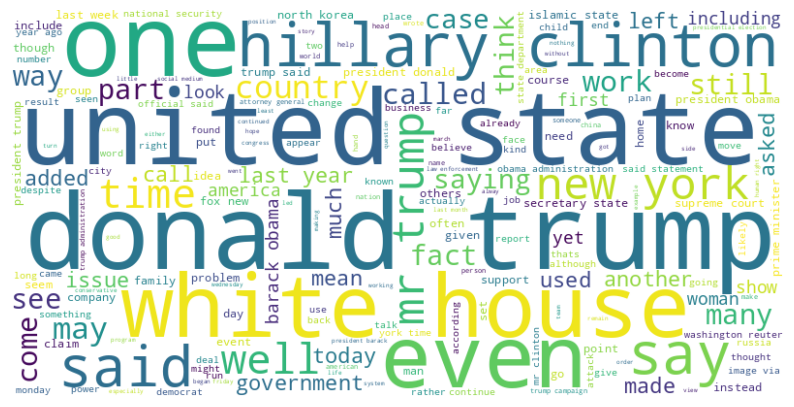

In [ ]:
all_text = ' '.join(df['cleaned_text'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# **Bag of Words (BoW) Feature Extraction**

In [ ]:
# Initialize CountVectorizer
count_vectorizer = CountVectorizer(max_features=1000)

bow_features = count_vectorizer.fit_transform(df['cleaned_text'])

bow_df = pd.DataFrame(bow_features.toarray(), columns=count_vectorizer.get_feature_names_out())

# Display Bag of Words features
print("Bag of Words Features:\n", bow_df.head())

df = df.join(bow_df, rsuffix='_bow')

print(df.head())

Bag of Words Features:
    ability  able  access  according  account  accused  across  act  action  \
0        0     0       0          0        0        0       0    0       0   
1        0     0       0          0        0        0       0    0       0   
2        0     0       0          0        0        0       0    0       0   
3        0     0       0          0        0        0       0    1       3   
4        0     1       0          1        0        0       0    0       0   

   activist  ...  would  wrong  wrote  year  yearold  yes  yet  york  young  \
0         0  ...      2      0      0     0        0    0    0     0      1   
1         0  ...      0      0      0     0        0    0    0     0      0   
2         0  ...      0      0      0     0        0    0    0     0      0   
3         4  ...      4      0      0     4        0    0    1     0      1   
4         0  ...      1      0      0     0        0    0    0     0      0   

   youre  
0      0  
1      0  

In [ ]:
print("Columns in bow_df:", bow_df.columns)
print("Data types of bow_df:\n", bow_df.dtypes)

Columns in bow_df: Index(['ability', 'able', 'access', 'according', 'account', 'accused',
       'across', 'act', 'action', 'activist',
       ...
       'would', 'wrong', 'wrote', 'year', 'yearold', 'yes', 'yet', 'york',
       'young', 'youre'],
      dtype='object', length=1000)
Data types of bow_df:
 ability      int64
able         int64
access       int64
according    int64
account      int64
             ...  
yes          int64
yet          int64
york         int64
young        int64
youre        int64
Length: 1000, dtype: object


In [ ]:
X = df.drop(columns=['title', 'text', 'label', 'cleaned_text'])
X = X.join(bow_df.add_suffix('_bow'), how='inner')

y = df['label']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (57707, 2001)
Shape of X_test: (14427, 2001)
Shape of y_train: (57707,)
Shape of y_test: (14427,)


In [ ]:
# After creating bow_df
bow_df = pd.DataFrame(bow_features.toarray(), columns=count_vectorizer.get_feature_names_out())

# First drop any existing _bow columns to prevent overlap
df = df.drop(columns=[col for col in df.columns if col.endswith('_bow')], errors='ignore')

# Now join with suffix
df = df.join(bow_df.add_suffix('_bow'))

# Prepare features
feature_columns = [col for col in df.columns if col not in ['title', 'text', 'label', 'cleaned_text']]
X = df[feature_columns]
y = df['label']

# Save feature information
joblib.dump(feature_columns, 'feature_columns.pkl')
joblib.dump(count_vectorizer, 'count_vectorizer.pkl')

['count_vectorizer.pkl']

In [ ]:
import os
print("feature_columns.pkl exists:", os.path.exists('feature_columns.pkl'))
print("count_vectorizer.pkl exists:", os.path.exists('count_vectorizer.pkl'))

feature_columns.pkl exists: True
count_vectorizer.pkl exists: True


# **Machine learning Models**

# **Logistic Regression model**

In [ ]:
# Initialize and train the Logistic Regression model
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

# Make predictions
y_pred = lr_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Logistic Regression Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.9359534206695779

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93      7089
           1       0.93      0.95      0.94      7338

    accuracy                           0.94     14427
   macro avg       0.94      0.94      0.94     14427
weighted avg       0.94      0.94      0.94     14427

Confusion Matrix:
 [[6552  537]
 [ 387 6951]]


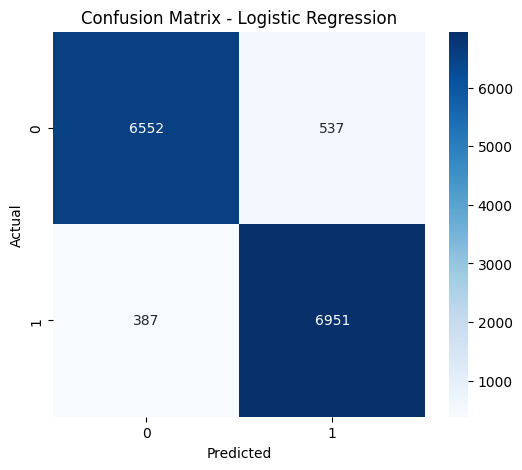

Model saved as 'logistic_regression_model.pkl'


In [ ]:
# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=lr_model.classes_, yticklabels=lr_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

# Save the model
joblib.dump(lr_model, 'logistic_regression_model.pkl')
print("Model saved as 'logistic_regression_model.pkl'")

# **Random forest**

In [ ]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Accuracy of Random Forest model:", accuracy_rf)

print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

Accuracy of Random Forest model: 0.9486379704720316

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.93      0.95      7089
           1       0.94      0.97      0.95      7338

    accuracy                           0.95     14427
   macro avg       0.95      0.95      0.95     14427
weighted avg       0.95      0.95      0.95     14427




Confusion Matrix:
 [[6599  490]
 [ 251 7087]]


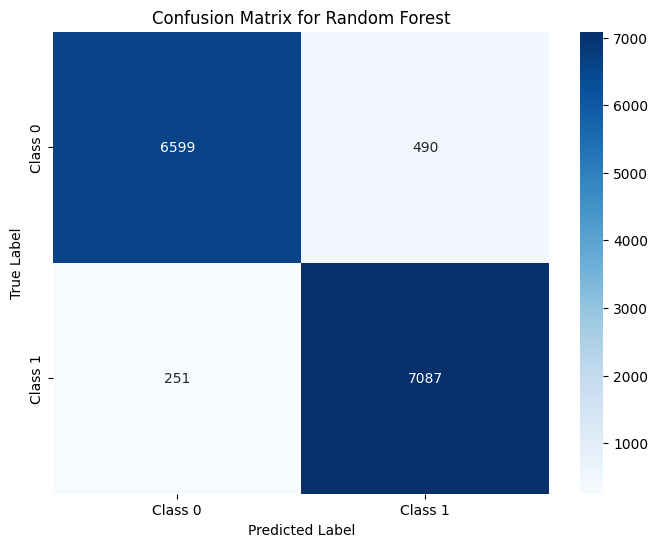

Random Forest model saved as 'random_forest_model.pkl'


In [ ]:
# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
print("\nConfusion Matrix:\n", cm_rf)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='g', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Save the Random Forest model
joblib.dump(rf_model, 'random_forest_model.pkl')
print("Random Forest model saved as 'random_forest_model.pkl'")

In [ ]:
# During training
count_vectorizer = CountVectorizer(max_features=1000)
bow_features = count_vectorizer.fit_transform(df['cleaned_text'])

# MUST save this to recreate the same features later
joblib.dump(count_vectorizer, 'count_vectorizer.pkl')

['count_vectorizer.pkl']

# **Deep Learning MOdels**

In [ ]:
# Preprocessing the Text Data
tokenizer = Tokenizer(num_words=2000, lower=True)
tokenizer.fit_on_texts(df['cleaned_text'])
X = tokenizer.texts_to_sequences(df['cleaned_text'])

# Pad sequences to ensure uniform input length
X = pad_sequences(X, maxlen=50)

# Encode the labels
le = LabelEncoder()
y = le.fit_transform(df['label'])

#  Split the Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  Build the LSTM Model
model = Sequential()

# Add an Embedding layer for text representation
model.add(Embedding(input_dim=2000, output_dim=32))

# Add Spatial Dropout to prevent overfitting
model.add(SpatialDropout1D(0.2))

# Add an LSTM layer with fewer units
model.add(LSTM(30, dropout=0.2, recurrent_dropout=0.2))

# Add a Dense layer for classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Train the Model with further reduced epochs and batch_size
history = model.fit(X_train, y_train, epochs=2, batch_size=16, validation_data=(X_test, y_test), verbose=1)

#  Evaluate the Model
y_pred_lstm = (model.predict(X_test) > 0.5).astype("int32")

# Calculate accuracy
accuracy_lstm = accuracy_score(y_test, y_pred_lstm)
print("Accuracy of LSTM model:", accuracy_lstm)

print("\nClassification Report:\n", classification_report(y_test, y_pred_lstm))

Epoch 1/2
3607/3607 ━━━━━━━━━━━━━━━━━━━━ 193s 52ms/step - accuracy: 0.8530 - loss: 0.3416 - val_accuracy: 0.9025 - val_loss: 0.2451
Epoch 2/2
3607/3607 ━━━━━━━━━━━━━━━━━━━━ 186s 52ms/step - accuracy: 0.9075 - loss: 0.2340 - val_accuracy: 0.9076 - val_loss: 0.2401
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
Accuracy of LSTM model: 0.9076037984334927

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.92      0.91      7089
           1       0.92      0.90      0.91      7338

    accuracy                           0.91     14427
   macro avg       0.91      0.91      0.91     14427
weighted avg       0.91      0.91      0.91     14427



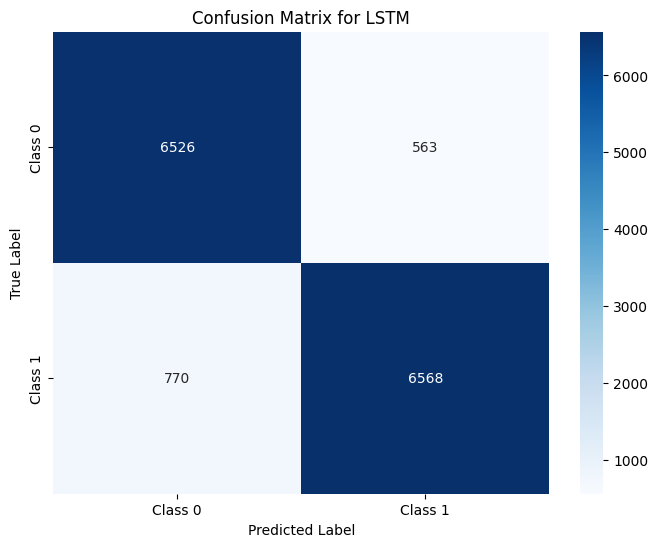

LSTM model saved as 'lstm_model.h5'


In [ ]:
# Confusion Matrix and Plot
cm_lstm = confusion_matrix(y_test, y_pred_lstm)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lstm, annot=True, fmt='g', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix for LSTM')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Save the model using Keras
model.save('lstm_model.h5')
print("LSTM model saved as 'lstm_model.h5'")

In [ ]:
# Save the Tokenizer
joblib.dump(tokenizer, 'tokenizer.pkl')
print("Tokenizer saved as 'tokenizer.pkl'")

# Save the Label Encoder
joblib.dump(le, 'label_encoder.pkl')
print("Label Encoder saved as 'label_encoder.pkl'")

Tokenizer saved as 'tokenizer.pkl'
Label Encoder saved as 'label_encoder.pkl'


# **Fake News Detection System with Multi-Model Analysis and Interactive Interface**

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from IPython.display import display, HTML
import ipywidgets as widgets

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# **Load Resources & Preprocessing**

In [ ]:
# Load resources with enhanced error handling
def load_resources():
    resources = {
        'models': {},
        'loaded_models': []
    }
    try:
        model_files = {
            'Logistic Regression': 'logistic_regression_model.pkl',
            'Random Forest': 'random_forest_model.pkl'
        }
        for name, file in model_files.items():
            try:
                resources['models'][name] = joblib.load(file)
                resources['loaded_models'].append(name)
            except Exception as e:
                print(f"Warning: Could not load {name} model - {str(e)}")

        try:
            resources['models']['LSTM'] = load_model('lstm_model.h5')
            resources['tokenizer'] = joblib.load('tokenizer.pkl')
            resources['label_encoder'] = joblib.load('label_encoder.pkl')
            resources['loaded_models'].append('LSTM')
        except Exception as e:
            print(f"Warning: Could not load LSTM components - {str(e)}")

        try:
            resources['count_vectorizer'] = joblib.load('count_vectorizer.pkl')
            resources['feature_columns'] = joblib.load('feature_columns.pkl')
        except Exception as e:
            print(f"Warning: Could not load feature preprocessing objects - {str(e)}")

    except Exception as e:
        print(f"Error loading resources: {e}")

    print(f"Successfully loaded models: {resources['loaded_models']}")
    return resources

resources = load_resources()

Successfully loaded models: ['Logistic Regression', 'Random Forest', 'LSTM']


# **Text Cleaning and Feature Preparation**

In [ ]:
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if not isinstance(text, str):
        return ""
    original_text = text
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    tokens = word_tokenize(text)
    text = ' '.join([lemmatizer.lemmatize(word) for word in tokens])
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'@\w+|#\w+|[^\x00-\x7F]+', '', text)
    return original_text, text

def prepare_traditional_features(cleaned_text):
    try:
        if 'count_vectorizer' not in resources or 'feature_columns' not in resources:
            raise ValueError("Required preprocessing resources not loaded")
        bow_features = resources['count_vectorizer'].transform([cleaned_text])
        bow_df = pd.DataFrame(bow_features.toarray(), columns=[f"{col}_bow" for col in resources['count_vectorizer'].get_feature_names_out()])
        features = pd.DataFrame(columns=resources['feature_columns'])
        features.loc[0] = 0
        for col in bow_df.columns:
            if col in features.columns:
                features[col] = bow_df[col]
        return features
    except Exception as e:
        print(f"Feature preparation error: {e}")
        return None

def prepare_lstm_input(cleaned_text):
    try:
        sequence = resources['tokenizer'].texts_to_sequences([cleaned_text])
        return pad_sequences(sequence, maxlen=50)
    except Exception as e:
        print(f"LSTM input preparation error: {e}")
        return None

# **Prediction & Visualization Functions**

In [ ]:
def predict_with_model(model, features, model_type='traditional'):
    if model_type == 'traditional':
        pred = model.predict(features)[0]
        proba = model.predict_proba(features)[0]
        return {
            'prediction': 'Real' if pred == 1 else 'Fake',
            'confidence': f"{max(proba)*100:.1f}%",
            'real_prob': f"{proba[1]*100:.1f}%",
            'fake_prob': f"{proba[0]*100:.1f}%"
        }
    else:
        pred = model.predict(features)[0][0]
        return {
            'prediction': 'Real' if pred > 0.5 else 'Fake',
            'confidence': f"{pred*100:.1f}%" if pred > 0.5 else f"{(1-pred)*100:.1f}%",
            'real_prob': f"{pred*100:.1f}%",
            'fake_prob': f"{(1-pred)*100:.1f}%"
        }

def plot_confidence(results_df):
    plt.figure(figsize=(10, 5))
    colors = ['green' if pred == 'Real' else 'red' for pred in results_df['Prediction']]
    confidences = results_df['Confidence'].str.replace('%', '').astype(float)
    bars = plt.bar(results_df['Model'], confidences, color=colors)
    plt.title('Model Confidence Levels', pad=20)
    plt.ylabel('Confidence (%)')
    plt.ylim(0, 110)
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height, f'{height:.1f}%', ha='center', va='bottom')
    real_patch = plt.Rectangle((0,0),1,1,fc="green")
    fake_patch = plt.Rectangle((0,0),1,1,fc="red")
    plt.legend([real_patch, fake_patch], ["Real", "Fake"], loc='upper right')
    plt.tight_layout()
    plt.show()

# **Interactive UI & Integration**

In [ ]:
text_input = widgets.Textarea(
    value='',
    placeholder='Paste news article here...',
    layout={'width': '100%', 'height': '200px'},
    description='Input:'
)

analyze_button = widgets.Button(
    description="Analyze",
    button_style='success',
    tooltip='Click to analyze the text'
)

output_area = widgets.Output()

def on_button_click(b):
    with output_area:
        output_area.clear_output()
        text = text_input.value.strip()
        if not text:
            display(HTML("<div style='color:red; padding:10px;'>Please enter some text to analyze</div>"))
            return
        try:
            original_text, cleaned_text = clean_text(text)
            display(HTML("<h3 style='color:#1a5276;'>Text Processing</h3>"))
            display(HTML("<h4>Original Text:</h4>"))
            display(HTML(f"<div style='background-color:#f8f9fa; padding:10px; border-radius:5px;'>{original_text}</div>"))
            display(HTML("<h4>Cleaned Text:</h4>"))
            display(HTML(f"<div style='background-color:#f8f9fa; padding:10px; border-radius:5px;'>{cleaned_text}</div>"))

            results = []
            available_models = []

            if all(k in resources for k in ['count_vectorizer', 'feature_columns']):
                features = prepare_traditional_features(cleaned_text)
                if features is not None:
                    for name in ['Logistic Regression', 'Decision Tree', 'Random Forest']:
                        if name in resources['models']:
                            try:
                                result = predict_with_model(resources['models'][name], features)
                                results.append({
                                    'Model': name,
                                    'Prediction': result['prediction'],
                                    'Real Probability': result['real_prob'],
                                    'Fake Probability': result['fake_prob'],
                                    'Confidence': result['confidence'],
                                    'Confidence_Value': float(result['confidence'].replace('%', ''))
                                })
                                available_models.append(name)
                            except Exception as e:
                                print(f"Error with {name}: {str(e)}")

            if 'LSTM' in resources['models']:
                lstm_features = prepare_lstm_input(cleaned_text)
                if lstm_features is not None:
                    try:
                        lstm_result = predict_with_model(resources['models']['LSTM'], lstm_features, 'lstm')
                        results.append({
                            'Model': 'LSTM',
                            'Prediction': lstm_result['prediction'],
                            'Real Probability': lstm_result['real_prob'],
                            'Fake Probability': lstm_result['fake_prob'],
                            'Confidence': lstm_result['confidence'],
                            'Confidence_Value': float(lstm_result['confidence'].replace('%', ''))
                        })
                        available_models.append('LSTM')
                    except Exception as e:
                        print(f"Error with LSTM: {str(e)}")

            if results:
                results_df = pd.DataFrame(results)
                display(HTML("<h3 style='color:#1a5276;'>Prediction Results</h3>"))
                display(results_df.drop('Confidence_Value', axis=1))
                plot_confidence(results_df)

                real_votes = sum(1 for r in results if r['Prediction'] == 'Real')
                total_models = len(results)
                consensus_msg = f"{real_votes} out of {total_models} models predict this is REAL news" if real_votes > total_models/2 else f"{total_models-real_votes} out of {total_models} models predict this is FAKE news"

                display(HTML(
                    f"<div style='margin-top:20px; padding:10px; background-color:#f0f0f0; border-radius:5px;'>"
                    f"<strong style='color:#1a5276;'>Consensus:</strong> {consensus_msg}</div>"
                ))
            else:
                display(HTML("<div style='color:red; padding:10px;'>No models available for prediction</div>"))
        except Exception as e:
            display(HTML(f"<div style='color:red; padding:10px;'><strong>Error:</strong> {str(e)}</div>"))

analyze_button.on_click(on_button_click)

box_layout = widgets.Layout(display='flex', flex_flow='column', align_items='stretch', width='100%')

display(HTML(
    "<div style='background-color:#f8f9fa; padding:20px; border-radius:10px;'>"
    "<h2 style='color:#1a5276; text-align:center;'>Fake News Detector</h2>"
    "<p style='text-align:center;'>Enter a news article or paragraph to analyze its authenticity</p>"
    "</div>"
))

display(widgets.VBox([text_input, analyze_button, output_area], layout=box_layout))